In [2]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,taufixed=False,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    
    if (taufixed):
        As=pars[3]
        ns=pars[4]
        #tau=0.05
        tau=0.0544
    else:
        tau=pars[3]
        As=pars[4]
        ns=pars[5]
    
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    tt=tt[2:1200+1:1] # slice to have multipoles match wmap
    return tt

<Figure size 432x288 with 0 Axes>

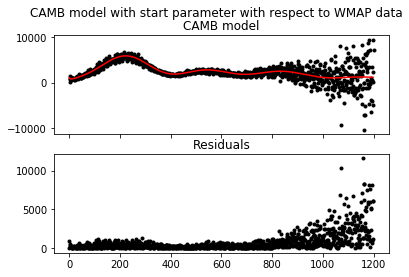

In [3]:
#pars=np.asarray([65,0.02,0.1,2e-9,0.96])
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
cmb=get_spectrum(pars)

plt.clf();

fig,(ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('CAMB model with start parameter with respect to WMAP data')

ax1.plot(wmap[:,0],wmap[:,1],'k.')
ax1.plot(cmb, 'r-')
ax1.set_title('CAMB model')

residuals = cmb-wmap[:,1]
for i in range(len(residuals)) :
    residuals[i] = np.abs(residuals[i])
ax2.plot(residuals, 'k.')
ax2.set_title('Residuals')

plt.show()

In [4]:
# 1. Evaluate chi-squared for the example script model

def get_chi2(wmap, cmb):
    chi2 = 0
    for i in range (len(wmap[:,1])):
        if (cmb[i] == 0 or wmap[i,1] == 0):
            chi2 += 0 
        else:
            chi2 += ((wmap[i,1] - cmb[i]) / wmap[i,2]) ** 2
    return chi2

guess_chi2 = get_chi2(wmap, cmb)
print("Chi^2: " + str(guess_chi2))

Chi^2: 1588.2376532931517


In [3]:
# CMB derivatives

def get_derivs(params, fun, dx_factor=0.1):
    derivs = np.zeros(shape=(len(params),1199))
    for i in range (len(params)):
                        
        params_new2l = np.copy(params)
        params_new1l = np.copy(params)
        params_new1r = np.copy(params)
        params_new2r = np.copy(params)
        
        dx = dx_factor * params[i]
        params_new2l[i] -= 2*dx
        params_new1l[i] -= dx
        params_new1r[i] += dx
        params_new2r[i] += 2*dx
            
        derivs[i,:] = (8*(fun(params_new1r)-fun(params_new1l))-(fun(params_new2r)-fun(params_new2l)))/ (12*dx) # 4 points derivative, O(dx^4f^(4)(x)))
        
    return np.transpose(derivs)

In [30]:
# 2. Optical depth tau = 0.05, using Newton's Method / Levenberg-Marquardt minimizer,best-fit values for the other parameters.
# Parameters: H0, ombh2, omch2, mnu, omk, tau

def LM_Minimizer(data, model, cov, params, num_iterations, prev_chi2=-1, prev_prev_chi2=-1, prev_damping_factor=1.0, scaling_factor=1.5):
    
    if (prev_chi2 == -1):
        prev_chi2 = get_chi2(data, get_spectrum(params))
    
    r = data[:,1] - model(params) # difference to data
    Am = get_derivs(params, model) # parameters derivatives
        
    # TODO covariance matrix
    lhs = np.dot(np.dot(np.transpose(Am), np.linalg.inv(cov)), Am) # Am^TN^(-1)Am
    rhs = np.dot(np.dot(np.transpose(Am), np.linalg.inv(cov)), r) # Am^tN^(-1)r

    # Levenbre-Marquart optimization
    damping_factor = prev_damping_factor
    if (prev_prev_chi2 != -1):
        if (prev_chi2 > prev_prev_chi2): # worse parameters
            damping_factor *= scaling_factor
        else: # better parameters
            damping_factor /= 2
            
    lhs += damping_factor * np.diag(lhs)
    
    
    deltam = np.dot(np.linalg.inv(lhs), rhs)
    params += deltam
    
    new_chi2 = get_chi2(data, get_spectrum(params))
    
    if (num_iterations == 1):
        return params
    
    return LM_Minimizer(data, model, covar, params, num_iterations-1, new_chi2, prev_chi2)


# covariance matrix - uncorrelated error
covar = np.zeros(shape=(len(wmap[:,1]), len(wmap[:,1])))
for i in range (len(wmap[:,1])):
    covar[i,i]=wmap[i,2]

#guess_params=np.array([65,0.02,0.1,2e-9,0.96])
guess_params=np.array([65,0.02,0.1,0.05,2e-9,0.96])
iterations=10
best_params=LM_Minimizer(wmap, get_spectrum, covar, guess_params, iterations)

initial chi2: 1588.2376532931517
iteration: 100
[6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
chi2: 1236.6519860006226
iteration: 99
[6.73884538e+01 2.25232517e-02 1.15698473e-01 3.34381363e-02
 2.00000000e-09 9.68160329e-01]
chi2: 1228.8002794893976
iteration: 98
[7.00092144e+01 2.27649307e-02 1.12415607e-01 4.01396557e-02
 2.00000000e-09 9.78355272e-01]
chi2: 1228.6189208327062
iteration: 97
[6.95653579e+01 2.26923861e-02 1.13230239e-01 3.91830510e-02
 2.00000000e-09 9.76053676e-01]
chi2: 1228.631846477113
iteration: 96
[6.96323173e+01 2.27027878e-02 1.13115824e-01 3.93241485e-02
 2.00000000e-09 9.76386968e-01]
chi2: 1228.6287367652271
iteration: 95
[6.96196801e+01 2.27008209e-02 1.13138046e-01 3.92967498e-02
 2.00000000e-09 9.76323304e-01]
chi2: 1228.6291537179516
iteration: 94
[6.96214895e+01 2.27011033e-02 1.13134891e-01 3.93006208e-02
 2.00000000e-09 9.76332304e-01]
chi2: 1228.629094042955
iteration: 93
[6.96212364e+01 2.27010635e-02 1.13135329e-01 3.93000912e-02
 2.00000000e

KeyboardInterrupt: 

1233.6042046338612
[7.46232980e+01 2.34400368e-02 1.04580297e-01 2.00000000e-09
 1.00109294e+00]


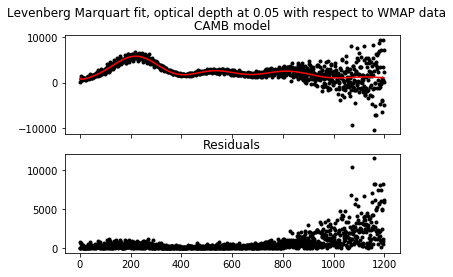

In [43]:
best_params = np.array([7.46232980e+01, 2.34400368e-02, 1.04580297e-01, 2.00000000e-09, 1.00109294e+00]) # from LM minimizer
cmb_bestfit = get_spectrum(best_params)
print(get_chi2(wmap, cmb_bestfit))
print(best_params)

fig,(ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Levenberg Marquart fit, optical depth at 0.05 with respect to WMAP data')

ax1.plot(wmap[:,0],wmap[:,1],'k.')
ax1.plot(cmb_bestfit, 'r-')
ax1.set_title('CAMB model')

residuals = cmb_bestfit-wmap[:,1]
for i in range(len(residuals)) :
    residuals[i] = np.abs(residuals[i])
ax2.plot(residuals, 'k.')
ax2.set_title('Residuals')

plt.show()

1228.629102551745
[6.96212638e+01 2.27010680e-02 1.13135285e-01 3.93001327e-02
 2.00000000e-09 9.76331187e-01]


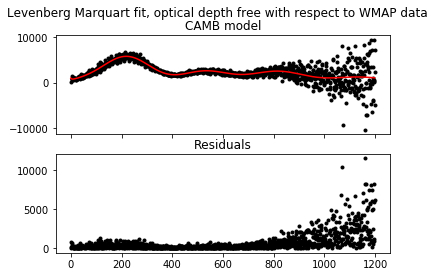

In [46]:
best_params = np.array([6.96212638e+01,2.27010680e-02,1.13135285e-01,3.93001327e-02,2.00000000e-09,9.76331187e-01])
cmb_bestfit = get_spectrum(best_params)
print(get_chi2(wmap, cmb_bestfit))
print(best_params)

fig,(ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Levenberg Marquart fit, optical depth free with respect to WMAP data')

ax1.plot(wmap[:,0],wmap[:,1],'k.')
ax1.plot(cmb_bestfit, 'r-')
ax1.set_title('CAMB model')

residuals = cmb_bestfit-wmap[:,1]
for i in range(len(residuals)) :
    residuals[i] = np.abs(residuals[i])
ax2.plot(residuals, 'k.')
ax2.set_title('Residuals')

plt.show()

In [5]:
# 3. MCMC

def priors(params):
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    
    if (tau > 0): # conditions
        return True
    else:
        return False
    
def priors_tauPlanck(params):
    return True
    
def prob(params, d_chi2):
    #isValid = priors_tauPlanck(params)
    isValid = priors(params)
    if not (isValid):
        return -1
    else:
        return np.exp(-0.5 * d_chi2)
    
def step(params, step_size_factor):
    new_params = params.copy()
    for i in range(len(new_params)):
        new_params[i] += np.random.normal() * new_params[i] * step_size_factor
    return new_params

# need to modify for right priors
def mcmc(start_params, data, model, iteration_tot, step_size_factor) :

    # Initalize variables
    iteration_cur = 1
    params = np.zeros(shape=(iteration_tot+1, len(start_params)))
    params[0, :] = start_params
    chi2s = np.zeros(iteration_tot+1)
    chi2s[0] = get_chi2(data, model(start_params))
    best_chi2 = chi2s[0]
    best_params = params[0, :]
    print(chi2s[0])
    
    # MCMC loop
    while(iteration_cur != iteration_tot):

        # Step size
        params[iteration_cur, :] = step(params[iteration_cur-1, :], step_size_factor)
        
        # Step probability
        chi2s[iteration_cur] = get_chi2(data, model(params[iteration_cur, :]))
        d_chi2 = chi2s[iteration_cur] - chi2s[iteration_cur-1]
        prob_step = prob(params, d_chi2)
                
        if (chi2s[iteration_cur] < best_chi2): # if best params
            best_chi2 = chi2s[iteration_cur]
            best_params = params[iteration_cur, :]
            print(chi2s[iteration_cur])
            iteration_cur+=1
            
        elif (np.random.rand(1) < prob_step): # accepted
            print(chi2s[iteration_cur])
            iteration_cur+=1  

    # end while
    
    return best_params, best_chi2, params, chi2s

In [6]:
# all parameters free
start_params = guess_params=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
step_size_factor = 1e-2
number_iterations = 1000

best_params, best_chi2, params, chi2s = mcmc(start_params, wmap, get_spectrum, number_iterations, step_size_factor)

1588.2376532931517
1523.42394448367


KeyboardInterrupt: 

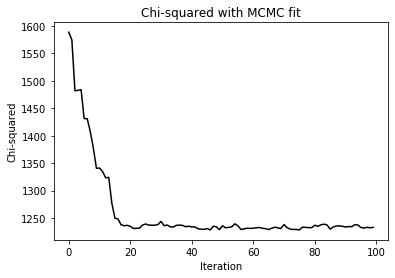

In [49]:
plt.clf()
plt.plot(chi2s[0:100:1], 'k-')
plt.title("Chi-squared with MCMC fit")
plt.xlabel("Iteration")
plt.ylabel("Chi-squared")
plt.show()

In [47]:
good_params = params[46]
print(good_params)

cmb_bestfit = get_spectrum(good_params)
print(get_chi2(wmap, cmb_bestfit))
print(good_params)

fig,(ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('MCMC fit with respect to the WMAP data')

ax1.plot(wmap[:,0],wmap[:,1],'k.')
ax1.plot(cmb_bestfit, 'r-')
ax1.set_title('CAMB model')

residuals = cmb_bestfit-wmap[:,1]
for i in range(len(residuals)) :
    residuals[i] = np.abs(residuals[i])
ax2.plot(residuals, 'k.')
ax2.set_title('Residuals')

plt.show()

[6.85906559e+01 2.24562400e-02 1.12382923e-01 2.03673678e-09
 9.65251497e-01]


IndexError: index 5 is out of bounds for axis 0 with size 5

<Figure size 432x288 with 0 Axes>

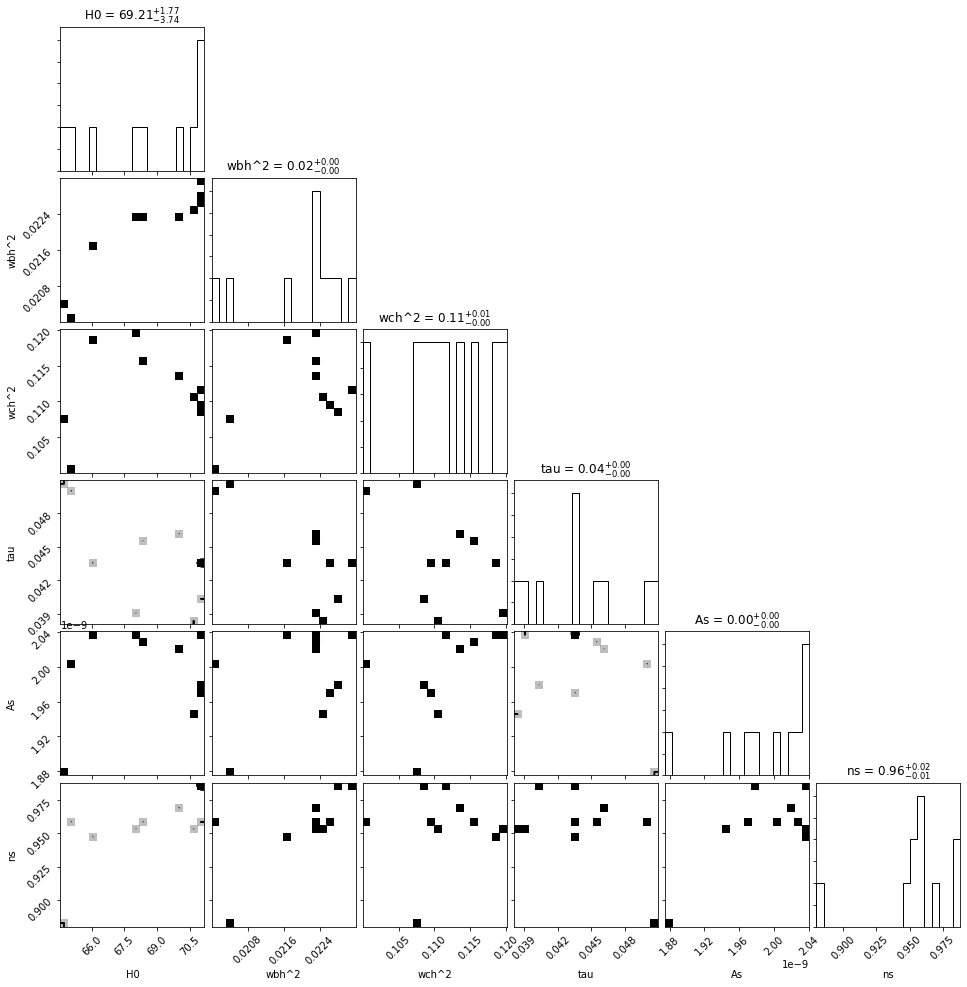

In [53]:
import corner
plt.clf()
corner.corner(params[0:100:11], labels=["H0","wbh^2","wch^2","tau","As","ns"], Title="MCMC parameters contour")
plt.show()

In [25]:
#4 mcmc with planck optical depth
start_params = np.asarray([65,0.02,0.1,2e-9,0.96])
step_size_factor = 1e-2
number_iterations = 100
best_params, best_chi2, params, chi2s = mcmc(start_params, wmap, get_spectrum, number_iterations, step_size_factor)

1516.6936246533273
1443.2202638619847
1373.0577100536652
1327.6869141885384
1311.9355706624926
1305.573686543746
1297.4512675826911
1266.9673410513624
1262.1191213754707
1257.005988377533
1249.4045111927721
1251.760236875816
1255.0493238821152
1247.7115621031146
1246.3808162972925
1242.4582988600177
1242.6467026512853
1242.8893530928224
1242.56047279437
1236.9823291710327
1240.1650036805383
1236.784271709263
1236.5780970524997
1234.9236409199407
1235.5464489032306
1234.5321130181428
1233.0702930002058
1233.6253305350003
1236.824013105324
1241.802806196916
1241.841728086884
1243.9121425320195
1241.550186465989
1240.4577423859268
1244.616981148075
1233.2035231060015
1230.859531530301
1230.6459370212922
1230.7285115829939
1229.7361775292627
1228.5099777255784
1229.596182793789
1234.328334279329
1233.926072272963
1229.9140973299432
1233.968103843079
1231.7818024771798
1232.4405908250005
1229.2397410856531
1232.4090850264854
1235.7981685362702
1233.9083092455096
1231.404125981386
1234.60363

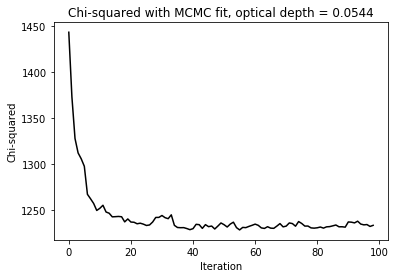

In [29]:
plt.clf()
plt.plot(chi2s[1:100:1], 'k-')
plt.title("Chi-squared with MCMC fit, optical depth = 0.0544")
plt.xlabel("Iteration")
plt.ylabel("Chi-squared")
plt.show()

1228.2353208808152
[6.96477910e+01 2.27256969e-02 1.13923671e-01 2.06804611e-09
 9.74638849e-01]


<Figure size 432x288 with 0 Axes>

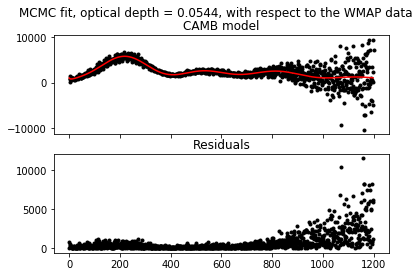

In [27]:
cmb_bestfit = get_spectrum(best_params)
print(best_chi2)
print(best_params)

plt.clf()

fig,(ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('MCMC fit, optical depth = 0.0544, with respect to the WMAP data')

ax1.plot(wmap[:,0],wmap[:,1],'k.')
ax1.plot(cmb_bestfit, 'r-')
ax1.set_title('CAMB model')

residuals = cmb_bestfit-wmap[:,1]
for i in range(len(residuals)) :
    residuals[i] = np.abs(residuals[i])
ax2.plot(residuals, 'k.')
ax2.set_title('Residuals')

plt.show()

<Figure size 432x288 with 0 Axes>

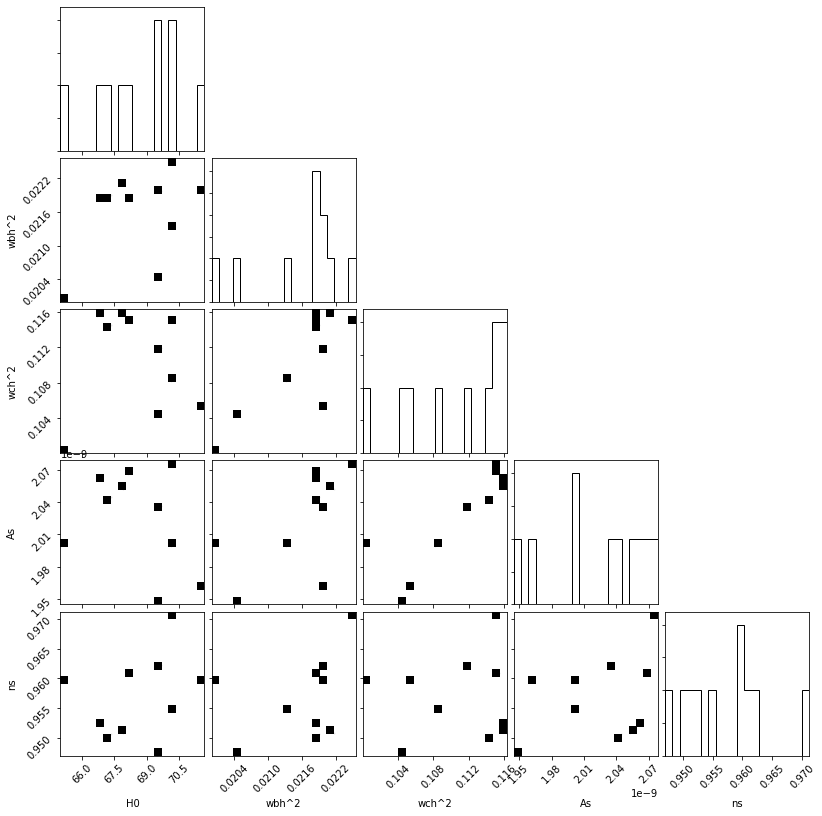

In [32]:
import corner
plt.clf()
corner.corner(params[0:100:11], labels=["H0","wbh^2","wch^2","As","ns"], Title="MCMC parameters contour, optical depth = 0.054")
plt.show()